In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string


In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
news_df = pd.read_csv('../data/processed/cleaned_news.csv')

In [21]:
news_df.head()

,index,title,text,subject,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count
0,38938,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,1,1245,130,0,0,4
1,9407,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,1,3157,117,0,5,14
2,2119,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,1,1994,76,0,1,0
3,32635,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,1,658,80,0,1,4
4,17073,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,1,2488,49,0,4,5


## 1: Text Preprocessing

### 1.1: Cleaning 
    - Converts text to lowercase.
    - Removes URLs, standalone numbers, and HTML tags.
    - Removes punctuation, newlines, and specific unicode punctuations.
    - Removes emojis using a regex pattern.
    - Expands common English contractions (e.g., "isn't" → "is not").
    - Removes extra whitespace.

In [17]:

def cleaning(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Remove newlines and specific unicode punctuations
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[’“”…]', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)

    # Expand contractions
    contractions = {
        "isn't": "is not", "he's": "he is", "wasn't": "was not", "there's": "there is",
        "couldn't": "could not", "won't": "will not", "they're": "they are", "she's": "she is",
        "wouldn't": "would not", "haven't": "have not", "that's": "that is", "you've": "you have",
        "what's": "what is", "weren't": "were not", "we're": "we are", "hasn't": "has not",
        "you'd": "you would", "shouldn't": "should not", "let's": "let us", "they've": "they have",
        "you'll": "you will", "i'm": "i am", "we've": "we have", "it's": "it is", "don't": "do not",
        "that´s": "that is", "i´m": "i am", "it’s": "it is", "she´s": "she is", "i’m": "i am",
        "i’d": "i did", "there’s": "there is"
    }

    for contraction, expanded in contractions.items():
        text = re.sub(rf"\b{re.escape(contraction)}\b", expanded, text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [23]:
new_text_df = news_df['text'].apply(cleaning)

In [30]:
new_text_df = pd.DataFrame(new_text_df)

new_text_df.head()

,text
0,the gay mafia has a new corporate don this is ...
1,does anyone really think hillary clinton will ...
2,the irony here isn t lost on us hillary is bei...
3,in case you missed it sen harry reid rnv who a...
4,nothing like political cronyism to make your s...


### 1.2: Removing the stop words from the text

In [31]:
# Removing the stop words from new_text_df
stop_words = stopwords.words()

stop_words_set = set(stop_words)

new_text_df['no_sw'] = new_text_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_set)]))

In [32]:
new_text_df.head()

,text,no_sw
0,the gay mafia has a new corporate don this is ...,gay mafia corporate article read sheer stupidi...
1,does anyone really think hillary clinton will ...,hillary clinton clean dug huge hole digging de...
2,the irony here isn t lost on us hillary is bei...,irony lost hillary compared president wanted n...
3,in case you missed it sen harry reid rnv who a...,case missed harry reid rnv announced week reti...
4,nothing like political cronyism to make your s...,political cronyism make stomach churn especial...


### 1.3: Removing the most frequent words: As they will introduce Bias

In [33]:
from collections import Counter

cnt = Counter()

for text in new_text_df['no_sw'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('trump', 105431),
 ('president', 44357),
 ('reuters', 28318),
 ('state', 27389),
 ('donald', 25142),
 ('states', 24455),
 ('house', 24215),
 ('government', 23544),
 ('republican', 22893),
 ('united', 21210)]

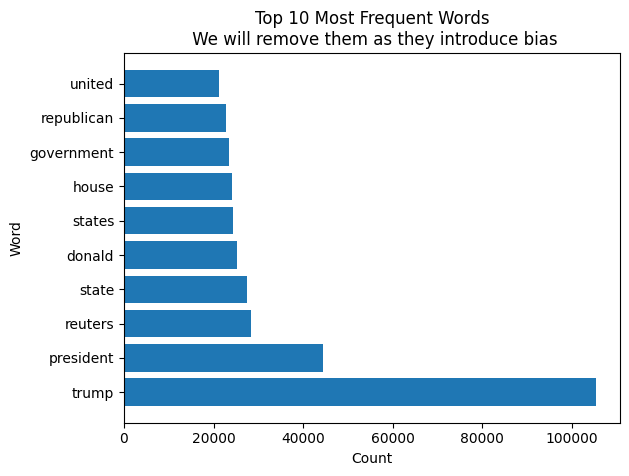

In [47]:
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']

plt.barh(temp['word'], temp['count'])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Words\n We will remove them as they introduce bias')
plt.show()

In [48]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

new_text_df["wo_stopfreq"] = new_text_df["no_sw"].apply(lambda text: remove_freqwords(text))
new_text_df.head()

,text,no_sw,wo_stopfreq
0,the gay mafia has a new corporate don this is ...,gay mafia corporate article read sheer stupidi...,gay mafia corporate article read sheer stupidi...
1,does anyone really think hillary clinton will ...,hillary clinton clean dug huge hole digging de...,hillary clinton clean dug huge hole digging de...
2,the irony here isn t lost on us hillary is bei...,irony lost hillary compared president wanted n...,irony lost hillary compared wanted nixon crimi...
3,in case you missed it sen harry reid rnv who a...,case missed harry reid rnv announced week reti...,case missed harry reid rnv announced week reti...
4,nothing like political cronyism to make your s...,political cronyism make stomach churn especial...,political cronyism make stomach churn especial...


## 2: Using a vectorizer with the lamitization.

In [70]:

!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --------- ------------------------------ 3.1/12.8 MB 11.3 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 15.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 15.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [71]:
import re
import string
import spacy
from nltk.corpus import stopwords

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define your domain-specific stopwords
FREQWORDS = set([
    'trump', 'president', 'reuters', 'state', 'donald',
    'states', 'house', 'government', 'republican', 'united'
])

# Combine with NLTK's standard English stopwords
custom_stopwords = set(stopwords.words()).union(FREQWORDS)

# Optional: Define a cleaning function (you already have this, but included for completeness)
def cleaning(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                     # Remove URLs
    text = re.sub(r'\b\d+\b', '', text)                                   # Remove standalone numbers
    text = re.sub(r'<.*?>', '', text)                                     # Remove HTML tags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)        # Remove punctuation
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[’“”…]', '', text)                                    # Remove special quotes
    emoji_pattern = re.compile("["                                        # Remove emojis
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)

    # Expand contractions
    contractions = {
        "isn't": "is not", "he's": "he is", "wasn't": "was not", "there's": "there is",
        "couldn't": "could not", "won't": "will not", "they're": "they are", "she's": "she is",
        "wouldn't": "would not", "haven't": "have not", "that's": "that is", "you've": "you have",
        "what's": "what is", "weren't": "were not", "we're": "we are", "hasn't": "has not",
        "you'd": "you would", "shouldn't": "should not", "let's": "let us", "they've": "they have",
        "you'll": "you will", "i'm": "i am", "we've": "we have", "it's": "it is", "don't": "do not",
        "that´s": "that is", "i´m": "i am", "it’s": "it is", "she´s": "she is", "i’m": "i am",
        "i’d": "i did", "there’s": "there is"
    }

    for contraction, expanded in contractions.items():
        text = re.sub(rf"\b{re.escape(contraction)}\b", expanded, text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Lemmatizer & tokenizer using spaCy and custom stopwords
def spacy_lemmatizer_tokenizer(text):
    """
    Applies spaCy lemmatization and filters tokens using a custom stopword list.
    Expects the input text to be cleaned beforehand.
    """
    doc = nlp(text.lower())

    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return tokens

# Final preprocessing function to plug into a vectorizer or pipeline
def preprocess(text):
    cleaned = cleaning(text)
    return spacy_lemmatizer_tokenizer(cleaned)
